# MNIST best results
Result	Method	Venue	Details
1. 0.21%	Regularization of Neural Networks using DropConnect	ICML 2013	
2. 0.23%	Multi-column Deep Neural Networks for Image Classiﬁcation	CVPR 2012	
3. 0.23%	APAC: Augmented PAttern Classification with Neural Networks	arXiv 2015	
4. 0.24%	Batch-normalized Maxout Network in Network	arXiv 2015	Details
5. 0.29%	Generalizing Pooling Functions in Convolutional Neural Networks: Mixed, Gated, and Tree	AISTATS 2016	Details
6. 0.31%	Recurrent Convolutional Neural Network for Object Recognition	CVPR 2015	

http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

In [1]:
%matplotlib inline

In [2]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam

# try leaky relu
from keras.layers.advanced_activations import LeakyReLU

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5103)


# Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# store labels on test set for visualization
test_labels = y_test

In [4]:
rows = 28
cols = 28

# theano input shape
input_shape = (1, rows, cols)

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
# vgg expects channels - here we have just one
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
x_train.shape

(60000, 1, 28, 28)

In [7]:
# convert to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalize
x_train /= 255
x_test /= 255

In [8]:
y_train.shape

(60000,)

In [9]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train.shape

(60000, 10)

In [10]:
y_train[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

# Define model

In [11]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [12]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [13]:
# Batchnorm + dropout + data augmentation
def create_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
Use keras's data augmentation.

In [14]:
batch_size = 512

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

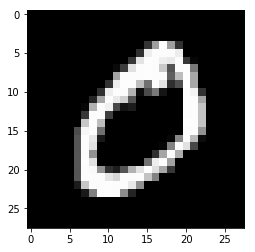

In [17]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[0], cmap='gray')

In [18]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [19]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

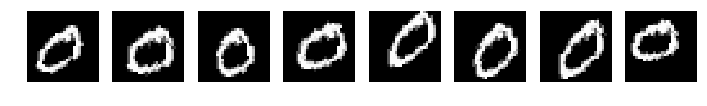

In [20]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

In [21]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening.
# gen.fit(x_train)

# Load models with pretrained weights
Here we build on previously trained models.

In [22]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights("weights/weights_leaky_relu_model_0.22_"+str(i)+'.pkl')    
    models.append(m)

# Ensembling
Here we create ten models and fit them to our augmented data. We use the mean prediction from all ten classifiers as our final prediction. This should average out errors in our classifiers and enable us to predict with higher accuracy.

In [ ]:
# fit the model on batches with real-time data augmentation
def fit_model(m):
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=1, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.1
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=4, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.01
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=12, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.001
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=18, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    return m

## Create and train ten models

In [ ]:
models = []

for i in range(10):
    print("Training model {}".format(i))
    m = fit_model(create_model())
    models.append(m)

In [ ]:
# train models some more if accuracy is not satisfying enough
for i, m in enumerate(models):
    m.optimizer.lr = 0.0001
    print("Model {}".format(i))
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=2,
                   validation_data=test_batches, validation_steps=validation_steps)

# Evaluate Model

In [23]:
eval_batch_size = 512

In [24]:
# evaluate every model
evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in models])

 9728/10000 [============================>.] - ETA: 0s

In [25]:
# calculate mean from evaluations
evals.mean(axis=0)

array([ 0.01117255,  0.99643   ])

In [26]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [27]:
all_preds.shape

(10, 10000, 10)

In [28]:
avg_preds = all_preds.mean(axis=0)
avg_preds.shape

(10000, 10)

In [29]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.2200007438659668

### Results
Activation "relu":
1. 0.26999711990356445
2. 0.26000142097473145 trained for one additional epoch

Activation "leaky relu":
1. 0.34000277519226074
2. 0.23999810218811035 + two epochs with lr 0.0001 (saved weights as _24)
3. 0.23000240325927734 + two epochs with lr 0.0001 (saved weights as _23)
4. 0.2200007438659668 + trained model 9 (out of 10) 6 additional epochs with lr 0.0001 (saved weights as _22)
5. 0.2200007438659668 + trained ALL models 8 additional epochs with lr 0.0001
6. 0.2200007438659668 + 2 additional epochs lr 0.0001
7. 0.23999810218811035 + 2 additional epochs lr 0.0001

# Show test error rate of every model separately
Two copies of the code to easily compare before/after additional training.

In [30]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

0 0.370001792908
1 0.330001115799
2 0.429999828339
3 0.349998474121
4 0.370001792908
5 0.340002775192
6 0.370001792908
7 0.360000133514
8 0.29000043869
9 0.360000133514


In [ ]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

# Train models for some additional epochs

In [ ]:
histories = []

for i, m in enumerate(models):
    m.optimizer.lr = 0.0001
    print("training model {}".format(i))
    history = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=1,
                   validation_data=test_batches, validation_steps=validation_steps)
    histories.append(history)

## Train single model

In [ ]:
# which model to train
i = 1

In [ ]:
models[i].optimizer.lr = 0.0001
history = models[i].fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=2,
                   validation_data=test_batches, validation_steps=validation_steps)

# Plot Training History

Jason Brownlee's script to plot model training history:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [ ]:
history = histories[0]

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Try evaluation only with best performing models
This doesn't seem to improve results at all.

In [31]:
best_model_numbers = [1,3,7,8,9]

In [32]:
best_models = []

for i in best_model_numbers:
    best_models.append(models[i])

In [33]:
# evaluate every model
evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in best_models])

 9728/10000 [============================>.] - ETA: 0s

In [34]:
# calculate mean from evaluations
evals.mean(axis=0)

array([ 0.01071539,  0.99662   ])

In [35]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in best_models])

In [36]:
all_preds.shape

(5, 10000, 10)

In [37]:
avg_preds = all_preds.mean(axis=0)
avg_preds.shape

(10000, 10)

In [38]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.26999711990356445

# Visualize model

In [ ]:
models[0].summary()

In [ ]:
# fix for python3
import pydotplus as pydot

from keras.utils import plot_model
plot_model(models[0], to_file='model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0]).create(prog='dot', format='svg'))

# Visualize predictions
As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).


TODO: get correct and incorrect labels

In [39]:
# predict classes
all_preds = np.stack([m.predict_classes(x_test, batch_size=eval_batch_size) for m in models])
# get probabilities
all_probs = np.stack([m.predict_proba(x_test, batch_size=eval_batch_size) for m in models])[:,0]

 9728/10000 [============================>.] - ETA: 0s

In [40]:
m = models[8]

# predict classes
preds = m.predict_classes(x_test, batch_size=eval_batch_size)
# get probabilities
probs = m.predict_proba(x_test, batch_size=eval_batch_size)[:,0]

 9728/10000 [============================>.] - ETA: 0s

In [127]:
preds.shape

(10000,)

In [128]:
probs.shape

(10000,)

In [129]:
# number of images to show
n_view = 6

In [130]:
preds

array([7, 2, 1, ..., 4, 5, 6])

In [131]:
probs

array([  1.64541203e-09,   5.95833114e-07,   2.17630330e-07, ...,
         1.42623597e-12,   1.49092530e-10,   2.17788784e-06], dtype=float32)

In [132]:
correct = np.where(preds==test_labels)[0]
incorrect = np.where(preds!=test_labels)[0]

In [133]:
correct.shape

(9971,)

In [134]:
incorrect.shape

(29,)

In [135]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [141]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [142]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [143]:
imgs.shape

(6, 1, 28, 28)

### a few correct labels at random

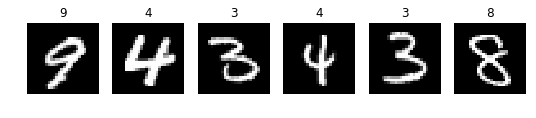

In [144]:
f = plt.figure(figsize=(12,6))

for i in range(n_view):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [150]:
# ground truth labels
test_labels[idx]

array([9, 4, 3, 4, 3, 8], dtype=uint8)

### a few incorrect labels at random

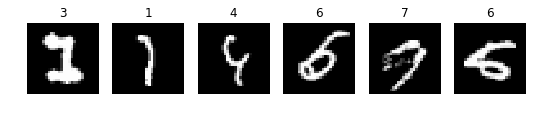

In [147]:
f = plt.figure(figsize=(12,6))

for i in range(n_view):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    sp.set_title(preds_incorrect[i])
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [151]:
# ground truth labels
test_labels[idx_incorrect]

array([1, 7, 9, 5, 9, 5], dtype=uint8)

# Save weights if model is accurate enough

In [ ]:
# save the weights for every classifier
for i, m in enumerate(models):
    m.save_weights("weights/weights_leaky_relu_model_0.2x_"+str(i)+'.pkl')